# 1. Introduction
I work in an office located in downtown Manhattan. Owing to the large number of businesses in this area and the high amount of footfall, I believe this area has a lot of useful data that can be analyzed to gain some insights.
Here is the link to the area that was used for the project:
http://www.openstreetmap.org/export#map=14/40.7195/-73.9858

# 2. Problems in the map data
Investigating the downloaded data uncovered the following issues / inconsistencies:
* Abbreviated street names / types
* Inconsistent zip codes
* Cities and counties
* Inconsistently formatted and inaccurate phone numbers

In [97]:
import csv
import codecs
import pprint
import re
import xml.etree.cElementTree as ET
import sqlite3
import string as s
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as pltly
from plotly.graph_objs import *

%matplotlib inline
%pylab inline

OSM_FILE='NYC.OSM'
DATABASE='OpenStreetMap.db'
mapbox_access_token='pk.eyJ1IjoibWVldG5hcmVuIiwiYSI6ImNqM3htbWtrMjAwMXUyd3BteXlpb2lmOXkifQ.tOV33V0Iv2N_Lqw--qqUwg'

pltly.tools.set_credentials_file(username='meetnaren', api_key='02FpawrSfFQjW88Ry5UA')

def connect_db():
    conn=sqlite3.connect(DATABASE)
    c=conn.cursor()
    return c

def execute_query(cursor, query):
    return pd.DataFrame(cursor.execute(query).fetchall())

def get_element(osm_file, tags=('node', 'way')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)

c=connect_db()

Populating the interactive namespace from numpy and matplotlib


## a) Street names
Let us look at the street names and unconver any abbreviated ones that can be fixed. I will audit each word in the street tags in the XML file to make sure we clean up everything before loading to the database.

Upon inspection of the dataset, the street names occur not only in the "addr:street" tags, but also under the "tiger" tags.

In [98]:
abbr_names = {
    "st":"Street",
    "ste":"Suite",
    "ave":"Avenue",
    "brg":"Bridge",
    "ct":"Court",
    "rd":"Road",
    "pl":"Place",
    "dr":"Drive",
    "sq":"Square",
    "ln":"Lane",
    "blvd":"Boulevard",
    "hwy":"Highway",
    "wy":"Way",
    "plz":"Plaza",
    "ctr":"Center",
    "n":"North",
    "w":"West",
    "s":"South",
    "e":"East"
    }

abbr_street_names={}

def find_abbr_street_names(elem):
    for tag in elem.iter('tag'):
        keytext=tag.attrib['k']
        if keytext.startswith('addr:street') or keytext.startswith('tiger:name_type'):
            words=tag.attrib['v'].split(' ')
            for word in words:
                word=word.translate(None,',.').lower()
                if word in abbr_names:
                    abbr_street_names[word]=abbr_street_names.get(word,0)+1
    return None

for elem in get_element(OSM_FILE):
    find_abbr_street_names(elem)

pprint.pprint(abbr_street_names)

{'ave': 632,
 'blvd': 57,
 'brg': 34,
 'ct': 6,
 'ctr': 1,
 'dr': 67,
 'e': 1,
 'hwy': 7,
 'ln': 10,
 'n': 2,
 'pl': 115,
 'plz': 24,
 'rd': 1,
 'sq': 29,
 'st': 2060,
 'w': 1}


It looks like there are quite a few abbreviated street names and types in the dataset. Let us fix them:

In [99]:
street_names={}
abbr_street_names={}

def clean_street_words(elem):
    for tag in elem.iter('tag'):
        keytext=tag.attrib['k']
        if keytext.startswith('addr:street') or keytext.startswith('tiger:name_type'):
            words=tag.attrib['v'].split(' ')
            cleaned_tag=' '.join(words)
            for word in words:
                # removing dots and commas, and converting to lowercase for comparison
                cleanword=word.translate(None,',.').lower()
                if cleanword in abbr_names:
                    words[words.index(word)]=abbr_names[cleanword]
                # There are some tags where the street name types are separated by a colon or semicolon like this:
                # 'Ave; St; Ave' or 'St; Plz; St'
                # the following lines of code are for fixing such cases
                elif cleanword[-1]==';' and cleanword[:-1] in abbr_names:
                    words[words.index(word)]=abbr_names[cleanword[:-1]]+';'
                elif cleanword[-1]==':' and cleanword[:-1] in abbr_names:
                    words[words.index(word)]=abbr_names[cleanword[:-1]]+':'
                cleaned_tag=' '.join(words)
            if cleaned_tag!=tag.attrib['v']:
                street_names[(tag.attrib['v'],cleaned_tag)]=street_names.get((tag.attrib['v'],cleaned_tag),0)+1
                tag.set('v',cleaned_tag)
    return elem

for elem in get_element(OSM_FILE):
    elem=clean_street_words(elem)
    find_abbr_street_names(elem)

pprint.pprint(street_names)
pprint.pprint(abbr_street_names)

{('110 SIXTH AVE. AT WATTS ST', '110 SIXTH Avenue AT WATTS Street'): 1,
 ('13th St.', '13th Street'): 1,
 ('15th st and 6th Avenue', '15th Street and 6th Avenue'): 1,
 ('1st St', '1st Street'): 25,
 ('2nd St', '2nd Street'): 19,
 ('334 Furman St, Brooklyn', '334 Furman Street Brooklyn'): 1,
 ('362nd Grand St', '362nd Grand Street'): 1,
 ('3rd St', '3rd Street'): 14,
 ('4th St', '4th Street'): 1,
 ('5th ave', '5th Avenue'): 1,
 ('Adams St', 'Adams Street'): 8,
 ('Ave', 'Avenue'): 603,
 ('Ave; Brg:Brg', 'Avenue; Brg:Brg'): 4,
 ('Ave; St; Ave', 'Avenue; Street; Avenue'): 3,
 ('Bloomfield St', 'Bloomfield Street'): 15,
 ('Blvd', 'Boulevard'): 57,
 ('Brg', 'Bridge'): 34,
 ('Brg; St', 'Bridge; Street'): 1,
 ('Broad St', 'Broad Street'): 1,
 ('Clinton St', 'Clinton Street'): 7,
 ('Ct', 'Court'): 6,
 ('Delancey St South', 'Delancey Street South'): 2,
 ('Devoe St.', 'Devoe Street'): 1,
 ('Dr', 'Drive'): 64,
 ('E. 4th Street', 'East 4th Street'): 1,
 ('East Houston St', 'East Houston Street'): 1

## b) Zip codes
Let us investigate the zip codes in the XML file. A quick inspection reveals that the zip codes are available under the tags with 'k'='addr:postcode' and also under the "tiger" tags. But, the "tiger" zipcode tags identify the zipcodes of the areas to the left and right of the "way" tags.

Nevertheless, let us investigate all zipcodes to identify the following issues: 
* All NYC zipcodes should start with '1'
* Let us consider only the first 5 chars of the zip codes. Any extensions will need to be truncated before loading to the database.

In [100]:
zipcodes={}

def audit_zipcodes(elem):
    for tag in elem.iter('tag'):
        keytext=tag.attrib['k']
        if keytext.startswith('addr:postcode') or keytext.startswith('tiger:zip'):
            if tag.attrib['v'][0]!='1' or len(tag.attrib['v'])!=5:
                zipcodes[tag.attrib['v']]=zipcodes.get(tag.attrib['v'],0)+1
    return None
    

for elem in get_element(OSM_FILE):
    audit_zipcodes(elem)
            
pprint.pprint(zipcodes)

{'07030': 141,
 '07030-5774': 1,
 '07050': 1,
 '07302': 65,
 '07302-4522': 1,
 '07304': 10,
 '07306': 4,
 '07310': 31,
 '07311': 2,
 '100014': 1,
 '10002-1013': 1,
 '10009:10010': 6,
 '10011-6832': 1,
 '10011; 10014': 14,
 '10011;10014': 2,
 '10012-3332': 1,
 '10012; 10011': 2,
 '11201-2483': 1,
 '11378; 11237': 6,
 '11378;11237': 4,
 'NY 10002': 1,
 'NY 10003': 3,
 'NY 10012': 1,
 'NY 11201': 2}


I noticed the following issues in the list of zipcodes above:
* There are zipcodes starting with zero. These belong to the state of New Jersey and the nodes or ways that have these zip codes should not be loaded into the database.
* There are some zip codes that have 4-digit extensions associated with them. These need to be truncated.
* There are zip codes that include the state code ("NY"). These need to be fixed.
* There is one typo (100014)
* There are cases where there are multiple zip codes separated by a ':', '-' or a ';'. These can be left as is.

In [101]:
def is_extension(zipcode):
    return zipcode.find('-')>-1

def is_state_code(zipcode):
    return zipcode[:2]=='NY'

def clean_zip_codes(elem):
    for tag in elem.iter('tag'):
        keytext=tag.attrib['k']
        if keytext.startswith('addr:postcode') or keytext.startswith('tiger:zip'):
            zipcode=tag.attrib['v']
            if is_extension(zipcode):
                zipcode=zipcode[:5]
            elif is_state_code(zipcode):
                zipcode=zipcode[3:8]
            elif zipcode=='100014':
                zipcode='10014'
            tag.set('v',zipcode)
            if zipcode.startswith('0'):
                elem.set('add','False')
    return elem
                
zipcodes={}

for elem in get_element(OSM_FILE):
    elem=clean_zip_codes(elem)
    audit_zipcodes(elem)

pprint.pprint(zipcodes)

{'07030': 142,
 '07050': 1,
 '07302': 66,
 '07304': 10,
 '07306': 4,
 '07310': 31,
 '07311': 2,
 '10009:10010': 6,
 '10011; 10014': 14,
 '10011;10014': 2,
 '10012; 10011': 2,
 '11378; 11237': 6,
 '11378;11237': 4}


## c) Counties
The "tiger" tags have a field called "County" in the XML file. Let us investigate county names in the file.

In [102]:
counties={}

def audit_counties(elem):
    for tag in elem.iter('tag'):
        if tag.attrib['k'].startswith('tiger:county'):
            counties[tag.attrib['v']]=counties.get(tag.attrib['v'],0)+1
    
for elem in get_element(OSM_FILE):
    audit_counties(elem)

pprint.pprint(counties)

{'Hudson, NJ': 193,
 'Kings, NY': 1132,
 'Kings, NY:New York, NY': 2,
 'Kings, NY; New York, NY': 3,
 'Kings, NY; New York, NY:New York, NY': 4,
 'Kings, NY; Queens, NY': 2,
 'Kings, NY;New York, NY': 3,
 'Kings, NY;New York, NY:New York, NY': 3,
 'New York, NY': 1514,
 'New York, NY; Kings, NY': 8,
 'New York, NY;Kings, NY': 2,
 'Queens, NY': 113,
 'Queens, NY; Kings, NY': 10,
 'Queens, NY;Kings, NY': 4}


We can see that while most of the entries are in New York, there are a few that belong to the state of New Jersey. The ways and nodes that have this attribute should not be loaded into the database. I will use a flag called 'add' at the element level for this purpose.

In [103]:
def clean_counties(elem):
    for tag in elem.iter('tag'):
        if tag.attrib['k'].startswith('tiger:county') and tag.attrib['v']=='Hudson, NJ':
            elem.set('add','False')
    return elem

## d) Phone numbers
Some of the nodes in the dataset are businesses with phone numbers. Unfortunately, phone numbers have been entered in various formats, such as:
* +1 844 462 7342
* 2129412614
* +1 212 791-9676
* +1 212.349.6555
and so on.

To deal with this issue, I need to find out all the different representations of phone numbers in the dataset. I will try to convert all phone numbers to the format +19999999999.

In [104]:
phone_number_chars=set()

def audit_phone_numbers(elem):
    for tag in elem.iter('tag'):
        if tag.attrib['k'].find('phone')>-1:
            phone=tag.attrib['v']
            for i in range(len(phone)):
                phone_number_chars.add(phone[i])
    return None

for elem in get_element(OSM_FILE):
    audit_phone_numbers(elem)

print phone_number_chars

set([' ', ')', '(', '+', '-', '.', '1', '0', '3', '2', '5', '4', '7', '6', '9', '8'])


Now we know all the different characters that we need filter out of the phone numbers in the dataset.

In [105]:
def clean_phone_numbers(elem):
    for tag in elem.iter('tag'):
        if tag.attrib['k'].find('phone')>-1:
            orig_phone=tag.attrib['v']
            phone=orig_phone.translate(None,' )(-.')
            if len(phone)==10: 
                phone='+1'+phone
            if len(phone)==11 and phone[0]=='1':
                phone='+'+phone
            if len(phone)!=12:
                print phone, orig_phone
    
for elem in get_element(OSM_FILE):
    clean_phone_numbers(elem)

+1212966998 +1 212 966998
212219954 (212) 219-954


We can see that there are two phone numbers that have one digit missing. I verified these nodes, looked up the information online $^{[1]}$ and fixed them in the code below.

In [106]:
#mapping the node IDs to the phone numbers
phone_numbers_dict={
    '2565708227':'+12129669983',
    '3147863535':'+12122199545'
}

phone_number_chars=set('+0123456789')

def clean_phone_numbers(elem):
    for tag in elem.iter('tag'):
        keytext=tag.attrib['k']
        if keytext.find('phone')>-1:
            orig_phone=tag.attrib['v']
            phone=orig_phone.translate(None,' )(-.')
            if len(phone)==10: 
                phone='+1'+phone
            if len(phone)==11 and phone[0]=='1':
                phone='+'+phone
            if len(phone)!=12:
                phone=phone_numbers_dict[elem.attrib['id']]
            tag.set('v',phone)
    return elem
    
for elem in get_element(OSM_FILE):
    elem=clean_phone_numbers(elem)
    audit_phone_numbers(elem)

print phone_number_chars

set(['+', '1', '0', '3', '2', '5', '4', '7', '6', '9', '8'])


## e) Cities
The address tags have a city attribute that can be investigated. This should be similar to the counties check that we did previously.

In [107]:
cities={}

def audit_cities(elem):
    for tag in elem.iter('tag'):
        if tag.attrib['k'].startswith('addr:city'):
            cities[tag.attrib['v']]=cities.get(tag.attrib['v'],0)+1
    
for elem in get_element(OSM_FILE):
    audit_cities(elem)

pprint.pprint(cities)

{'Blissville': 1,
 'Brooklyn': 427,
 'Brooklyn, NY': 4,
 'Brooklyn, New York': 1,
 'Hoboken': 152,
 'Jersey City': 15,
 'Long Island City': 2,
 'Manhattan NYC': 1,
 'NEW YORK CITY': 3,
 'New York': 1608,
 'New York CIty': 2,
 'New York City': 122,
 'New York, NY': 4,
 'Tribeca': 2,
 'York City': 1,
 'brooklyn': 1,
 'new york': 2}


I can see the following issues with the list of cities in the dataset.
* Clearly some of them belong to the state of New Jersey (Jersey City, Hoboken). These nodes should not be loaded into the database
* Some of the city names have the state code attached to them (Brooklyn, NY)
* Inconsistent capitalization
* New York is represented in a variety of different ways (New York City, Manhattan NYC, York City, etc.)
* Neigborhoods are depicted as a separate city (Tribeca, Blissville)

I will try resolving these issues thusly:

In [108]:
city_mappings={
    'Blissville':'Long Island City',
    'Brooklyn, Ny':'Brooklyn',
    'Brooklyn, New York':'Brooklyn',
    'Manhattan Nyc':'New York',
    'New York City':'New York',
    'New York, Ny': 'New York',
    'York City':'New York',
    'Tribeca':'New York'
}

cities={}

def clean_cities(elem):
    for tag in elem.iter('tag'):
        if tag.attrib['k'].startswith('addr:city'):
            city=s.capwords(tag.attrib['v']) # this takes care of incorrect capitalization of words
            if city in city_mappings:
                city=city_mappings[city]
            tag.set('v',city)
            if tag.attrib['v'] in ['Hoboken', 'Jersey City']:
                elem.set('add','False')
    return elem
    
for elem in get_element(OSM_FILE):
    elem=clean_cities(elem)
    audit_cities(elem)
            
pprint.pprint(cities)

{'Brooklyn': 433,
 'Hoboken': 152,
 'Jersey City': 15,
 'Long Island City': 3,
 'New York': 1745}


# 3. Preparing data to load into the database
In order to prepare data, I will make use of the shape_element function used in the case study, in conjunction with the cleaning functions described above.

In [109]:
NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

    for tag in element.iter('tag'):
        if problem_chars.search(tag.attrib['k']):
            continue
        tagdict={}
        tagdict['id']=element.attrib['id']
        colonpos=tag.attrib['k'].find(':')
        if colonpos>-1:
            tagdict['key']=tag.attrib['k'][colonpos+1:]
            tagdict['type']=tag.attrib['k'][:colonpos]
        else:
            tagdict['key']=tag.attrib['k']
            tagdict['type']=default_tag_type
        tagdict['value']=tag.attrib['v']
        tags.append(tagdict)

    if element.tag == 'node':
        for a in element.attrib:
            if a in node_attr_fields:
                node_attribs[a]=element.attrib[a]
        return {'node': node_attribs, 'node_tags': tags}
    elif element.tag == 'way':
        for a in element.attrib:
            if a in way_attr_fields:
                way_attribs[a]=element.attrib[a]

        pos=0
        for pos, nd in enumerate(element.iter('nd')):
            nodedict={}
            nodedict['id']=element.attrib['id']
            nodedict['node_id']=nd.attrib['ref']
            nodedict['position']=pos
            way_nodes.append(nodedict)            
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}

I will call the clean up functions before the shape_element function is called.

In [110]:
with codecs.open(NODES_PATH, 'w') as nodes_file, \
     codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
     codecs.open(WAYS_PATH, 'w') as ways_file, \
     codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
     codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

    nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
    node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
    ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
    way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
    way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

    nodes_writer.writeheader()
    node_tags_writer.writeheader()
    ways_writer.writeheader()
    way_nodes_writer.writeheader()
    way_tags_writer.writeheader()

    for element in get_element(OSM_FILE):
        element.set('add','True')
        element=clean_street_words(element)
        element=clean_zip_codes(element)
        element=clean_phone_numbers(element)
        element=clean_counties(element)
        element=clean_cities(element)
        if element.attrib['add']=='False':
            continue
        el = shape_element(element)
        if el:
            if element.tag == 'node':
                nodes_writer.writerow(el['node'])
                node_tags_writer.writerows(el['node_tags'])
            elif element.tag == 'way':
                ways_writer.writerow(el['way'])
                way_nodes_writer.writerows(el['way_nodes'])
                way_tags_writer.writerows(el['way_tags'])

# 4. Data analysis
I have created the tables in the database using the schema found here:
https://gist.github.com/swwelch/f1144229848b407e0a5d13fcb7fbbd6f

## File sizes

## No. of nodes, ways and users
Let us write some queries to check the no. of nodes, ways and the no. of unique users in the database.

In [120]:
c=connect_db()

# No. of nodes
query = 'SELECT COUNT(*) FROM NODES'
print "No. of nodes: ", execute_query(c,query)[[0]][0][0]

# No. of ways
query = 'SELECT COUNT(*) FROM WAYS'
print "No. of ways: ", execute_query(c,query)[[0]][0][0]

# No. of distinct users from both nodes and ways tables
query = 'SELECT COUNT(*) FROM (SELECT DISTINCT(UID) FROM NODES UNION SELECT DISTINCT(UID) FROM WAYS)'
print "No. of unique users: ", execute_query(c,query)[[0]][0][0]

No. of nodes:  249935
No. of ways:  44323
No. of unique users:  1095


## Additional data analysis
Let us do some additional analysis of the data in the database. There are various types of amenities in the NYC area. Let's find out which ones are the most common.

### Top amenities by count

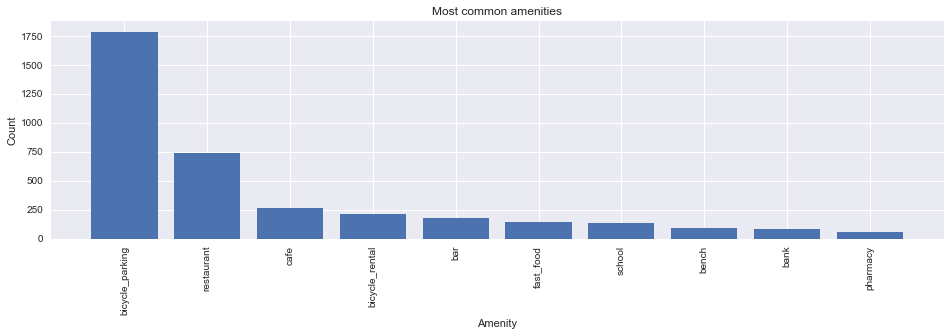

In [112]:
def groupByPlot(df,title,xlabel):
    plt.figure(figsize=(16,4))
    plt.bar(range(len(df)),df[1].tolist())
    plt.xticks(range(len(df)),df[0].tolist(),rotation='vertical')
    plt.ylabel('Count')
    plt.xlabel(xlabel)
    plt.title(title)
    
query = 'SELECT VALUE, COUNT(*) FROM NODES_TAGS WHERE KEY="amenity" GROUP BY VALUE ORDER BY COUNT(*) DESC LIMIT 10'
df=pd.DataFrame(execute_query(c,query))

groupByPlot(df,'Most common amenities','Amenity')

### Bicycle parking - capacity
Let us investigate the bicycle parking spaces. I noticed that most of the bicycle parking nodes have a capacity tag too. Can we find out the total bicycle parking capacity in New York City?

In [113]:
query = 'SELECT VALUE FROM NODES_TAGS WHERE KEY="capacity" AND ID IN (SELECT ID FROM NODES_TAGS WHERE KEY="amenity" AND VALUE="bicycle_parking")'
df=execute_query(c,query)

print sum(pd.to_numeric(df[0]))

6460


### Restaurants, cafes and bars
Which localities have the highest number of restaurants, cafes and bars? Let us try grouping the amenities by zipcode.

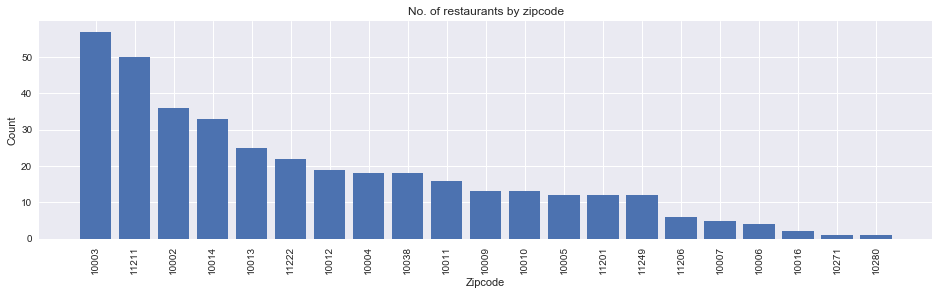

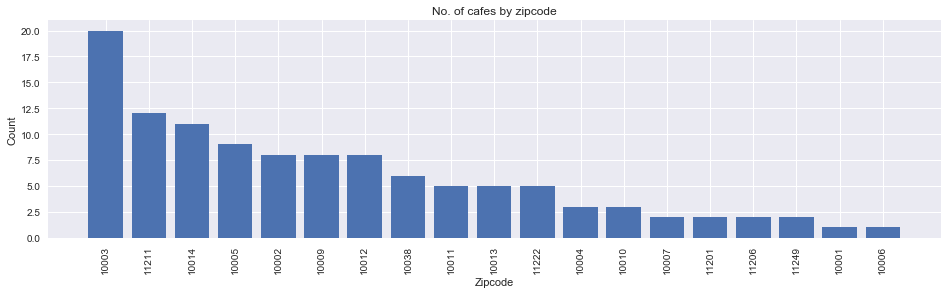

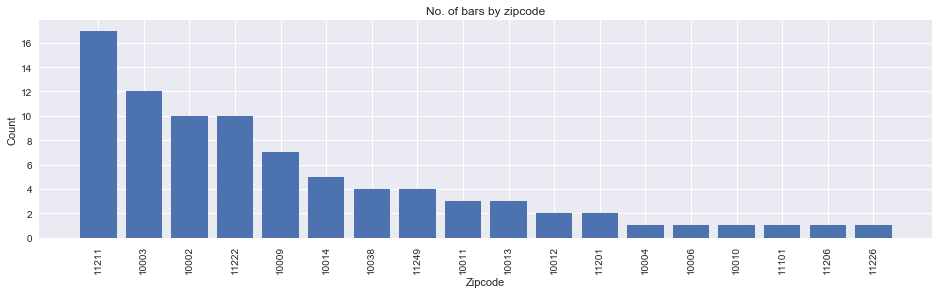

In [114]:
def amenities_by_zipcode(c,amenity):
    query='SELECT VALUE, COUNT(*) FROM NODES_TAGS WHERE KEY="postcode" AND ID IN (SELECT ID FROM NODES_TAGS WHERE KEY="amenity" AND VALUE="'+amenity+'") GROUP BY VALUE ORDER BY COUNT(*) DESC'
    return execute_query(c,query)

amenities=['restaurant','cafe','bar']

for i in range(len(amenities)):
    plt.figure(i)
    df=amenities_by_zipcode(c,amenities[i])
    groupByPlot(df,'No. of '+amenities[i]+'s by zipcode','Zipcode')

### Ways
Let us focus on the way tags now. How many one-way roads are in the map area we selected?

In [115]:
query = 'SELECT VALUE, COUNT(*) FROM WAYS_TAGS WHERE KEY="oneway" AND VALUE IN ("yes","no") GROUP BY VALUE'
df=execute_query(c,query)
df.columns=['One-way?','Count']
print df

  One-way?  Count
0       no    333
1      yes   2295


A majority of the ways are one-way. It's not surprising. But there are only around 2500 ways tagged with Yes or No? Hmmm...

Which ways have the highest number of nodes and tags?

In [116]:
query = 'SELECT A.ID, B.VALUE, COUNT(*) FROM WAYS_NODES A, WAYS_TAGS B WHERE A.ID=B.ID AND B.KEY="name" GROUP BY A.ID ORDER BY COUNT(*) DESC LIMIT 10'
df=execute_query(c,query)
df.columns=['ID','Name','No. of nodes']
print df

          ID                      Name  No. of nodes
0   27459219        Liberty State Park           259
1  400014249                 Manhattan           187
2   96021655  Hudson-Bergen Light Rail           161
3   56469108      Brooklyn Bridge Park           149
4   11629982  Hudson-Bergen Light Rail           148
5  442439749      East River Esplanade           136
6  109442847        Brooklyn Navy Yard           124
7  278076378                   75 Wall           123
8  391259934       Williamsburg Bridge           115
9  241856540             Cadman Towers           114


In [117]:
query = 'SELECT A.ID, B.VALUE, COUNT(*) FROM WAYS_TAGS A, WAYS_TAGS B WHERE A.ID=B.ID AND B.KEY="name" GROUP BY A.ID ORDER BY COUNT(*) DESC LIMIT 10'
df=execute_query(c,query)
df.columns=['ID','Name','No. of tags']
print df

          ID                        Name  No. of tags
0   46714308      Long Island Expressway           24
1   46722009      Long Island Expressway           24
2  264768896           Flatiron Building           24
3  278039438          John Street Church           24
4   46722012      Long Island Expressway           23
5   46819901  Brooklyn-Queens Expressway           23
6  122625703  Brooklyn-Queens Expressway           23
7  147229978      One World Trade Center           23
8  183103093  Brooklyn-Queens Expressway           23
9  183103103  Brooklyn-Queens Expressway           23


### Geographical plotting
I want to make use of the latlon data in the XML file and plot some points of interest on a geographical map. Let us look at the restaurants, cafes and bars in the NYC area. I will use the plotly package to create this plot $^{[3]}$

In [118]:
query = 'SELECT A.LAT, A.LON, B.VALUE, C.VALUE FROM NODES A, NODES_TAGS B, NODES_TAGS C WHERE A.ID=B.ID AND B.ID=C.ID AND B.KEY="amenity" AND B.VALUE IN ("restaurant", "cafe", "bar") AND C.KEY="name"'
df=execute_query(c,query)
df.columns=['Lat','Lon','Amenity_type','Name']

data=Data([
    Scattermapbox(
        lat=df['Lat'],
        lon=df['Lon'],
        mode='markers',
        marker=Marker(
            size=5,
            color=df['Amenity_type'].astype('category').cat.codes.values,
            colorscale='Viridis',
            #showscale=True
            colorbar=dict(
                tickmode='array',
                tickvals=[0,1,2],
                ticktext=['bar','cafe','restaurant'],
                ticks='inside'
            )
        ),
        text=df['Name']        
    )
])

layout=Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.71955,
            lon=-73.9858
        ),
        pitch=0,
        zoom=12
    ),
    showlegend=False
)

fig = dict(data=data, layout=layout)

pltly.plotly.iplot(fig)


We can see that while there are a lot of restaurants and cafes in the Financial district, there are a lot of bars in the East Village area.

# Other ideas about the dataset
I could see that there are quite a number of problems with the dataset.
* There are many businesses that are missing from the dataset. This could be because 
    * Businesses are not as interested in adding their data on OpenStreetMap as they are in adding them on Google Maps
    * Contributors are not inclined to add business data
* Addresses are missing for many buildings in the dataset. Even though we cleaned up the data to remove nodes from the New Jersey area, we could see in the geographical plot that there are some nodes that still show up in New Jersey. This was due to the lack of zipcodes attached to these nodes
* The total no. of ways in the dataset was around 44k. But, as we saw in one of the queries, only around 2500 ways were tagged with the one-way key. Improving this data would highly improve accuracy of routing directions from one node to another

Having said that, I should also mention that given that all the data in OpenStreetMap is sourced from voluntary contributors, the level of detail available is really astounding. OpenStreetMap is an absolute treasure trove of information and I think with time, the accuracy and quantity of information will definitely improve.

# References
1. Phone numbers with a missing digit:
    * http://www.cafekatja.com/
    * https://www.pepolino.com
2. Closed way: http://wiki.openstreetmap.org/wiki/Way#Closed_way
3. https://plot.ly/python/scattermapbox/